In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time

In [2]:
import pandas as pd
realDF = pd.read_csv('../data-processing/cresci-2017/genuine_accounts_processed.csv')
ss1DF = pd.read_csv('../data-processing/cresci-2017/social_spambots_1_processed.csv')
ss2DF = pd.read_csv('../data-processing/cresci-2017/social_spambots_2_processed.csv')
ss3DF = pd.read_csv('../data-processing/cresci-2017/social_spambots_3_processed.csv')
ffDF = pd.read_csv('../data-processing/cresci-2017/fake_followers_processed.csv')
ts1DF = pd.read_csv('../data-processing/cresci-2017/traditional_spambots_1_processed.csv')
coaDF = pd.read_csv('../data-processing/college-official-accounts/coa_processed.csv')
v2019DF = pd.read_csv('../data-processing/verified-2019/v2019_processed.csv')


In [3]:
v2019DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1953 non-null   int64  
 1   status                    1953 non-null   float64
 2   follower                  1953 non-null   float64
 3   friend                    1953 non-null   float64
 4   favorite                  1953 non-null   float64
 5   listed                    1953 non-null   float64
 6   follower_over_friend      1953 non-null   float64
 7   follower_minus_friend     1953 non-null   float64
 8   favorite_over_friend      1953 non-null   float64
 9   status_over_friend        1953 non-null   float64
 10  url                       1953 non-null   float64
 11  url_facebook              1953 non-null   float64
 12  url_instagram             1953 non-null   float64
 13  url_youtube               1953 non-null   float64
 14  url_blog

In [4]:
# removing some entries from data
del coaDF['url_youtube'], v2019DF['url_youtube']
del coaDF['favorite'], realDF['favorite'], ss1DF['favorite'], ss2DF['favorite'], ss3DF['favorite'], ffDF['favorite'], ts1DF['favorite'], v2019DF['favorite']
del coaDF['Unnamed: 0'], realDF['Unnamed: 0'], ss1DF['Unnamed: 0'], ss2DF['Unnamed: 0'], ss3DF['Unnamed: 0'], ffDF['Unnamed: 0'], ts1DF['Unnamed: 0'], v2019DF['Unnamed: 0']
del coaDF['favorite_over_friend'], realDF['favorite_over_friend'], ss1DF['favorite_over_friend'], ss2DF['favorite_over_friend'], ss3DF['favorite_over_friend'], ffDF['favorite_over_friend'], ts1DF['favorite_over_friend'], v2019DF['favorite_over_friend']

In [23]:
del coaDF['geo'], realDF['geo'], ss1DF['geo'], ss2DF['geo'], ss3DF['geo'], ffDF['geo'], ts1DF['geo'], v2019DF['geo']

In [24]:
def data_split (df, split=0.7):
    train_num = int(len(df.index)*split)
    return df.iloc[:train_num,:], df.iloc[train_num+1:,:]

realTrain, realTest = data_split(realDF)
ss1Train, ss1Test = data_split(ss1DF)
ss2Train, ss2Test = data_split(ss2DF)
ss3Train, ss3Test = data_split(ss3DF)
ts1Train, ts1Test = data_split(ts1DF)
ffTrain, ffTest = data_split(ffDF)
coaTrain, coaTest = data_split(coaDF)
v2019Train, v2019Test = data_split(v2019DF)

In [25]:
print(coaTrain.shape, v2019Train.shape)

(2499, 47) (1367, 47)


In [26]:
def trainRF (reals, bots, n_estimators=100):

    data = pd.concat(reals+bots).fillna(0).to_numpy()
    target = np.array([0] * sum(len(real.index) for real in reals) + [1] * sum(len(bot.index) for bot in bots))
    rfc = RandomForestClassifier(n_estimators=n_estimators)
    rfc = rfc.fit(data, target)
    return rfc

In [27]:
def testRF(reals, bots, RF):
    data = pd.concat(reals+bots).fillna(0).to_numpy()
    target = np.array([0] * sum(len(real.index) for real in reals) + [1] * sum(len(bot.index) for bot in bots))
    return RF.score(data, target)

In [28]:
def testRF_ESC(reals, bots, RFs):
    data = pd.concat(reals+bots).fillna(0).to_numpy()
    target = np.array([0] * sum(len(real.index) for real in reals) + [1] * sum(len(bot.index) for bot in bots))
    totalAccNum = 0
    for i in range(data.shape[0]):
        catScore = [float(RFs[0].predict_proba([data[i]])[0][0])] + [float(RF.predict_proba([data[i]])[0][1]) for RF in RFs[1:]]
        if target[i] == 0 and catScore[0] == max(catScore) or target[i] == 1 and catScore[0] != max(catScore):
            totalAccNum += 1
        else:    
            print("Pred", i, target[i], catScore)
    return float(totalAccNum)/data.shape[0]

In [29]:
real_detect_RF = []
real_detect_RF.append(trainRF([realTrain], [ss1Train, ss2Train, ss3Train, ffTrain, ts1Train, coaTrain, v2019Train]))
real_detect_RF.append(trainRF([realTrain], [ss1Train, ss2Train, ss3Train]))
real_detect_RF.append(trainRF([realTrain], [ts1Train]))
real_detect_RF.append(trainRF([realTrain], [coaTrain]))
real_detect_RF.append(trainRF([realTrain], [ffTrain]))
real_detect_RF.append(trainRF([realTrain], [v2019Train]))

In [30]:
print(testRF([realTest], [ss1Test, ss2Test, ss3Test, ffTest, ts1Test, coaTest, v2019Test], real_detect_RF[0]))

0.9917808219178083


In [31]:
start_time = time.time()
importances = real_detect_RF[0].feature_importances_
std = np.std([tree.feature_importances_ for tree in real_detect_RF[0].estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.014 seconds


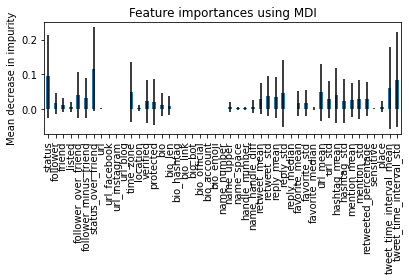

In [32]:
forest_importances = pd.Series(importances, index=realTrain.columns.values.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
correctRate = testRF_ESC([realTest], [ss1Test, ss2Test, ss3Test, ffTest, ts1Test, coaTest, v2019Test], real_detect_RF)

In [22]:
print(correctRate)

0.9914155251141552


In [21]:
print(realTrain.geo.tolist().count(1.0) / len(realTrain.geo.tolist()))
print(coaTrain.geo.tolist().count(1.0 / len(coaTrain.geo.to_list())))

0.6190867955573838
0


In [25]:
v2019DF.to_pickle('v2019-pickled')

In [26]:
RF = []
RF.append(trainRF([v2019Train], [ss1Train, ss2Train, ss3Train, ffTrain, ts1Train, coaTrain, realTrain]))
RF.append(trainRF([v2019Train], [ss1Train, ss2Train, ss3Train]))
RF.append(trainRF([v2019Train], [ts1Train]))
RF.append(trainRF([v2019Train], [coaTrain]))
RF.append(trainRF([v2019Train], [ffTrain]))
RF.append(trainRF([v2019Train], [realTrain]))

In [27]:
print(testRF([v2019Test], [ss1Test, ss2Test, ss3Test, ffTest, ts1Test, coaTest, realTest], RF[0]))

0.9735159817351599


In [28]:
correctRate = testRF_ESC([v2019Test], [ss1Test, ss2Test, ss3Test, ffTest, ts1Test, coaTest, realTest], RF)

Pred 3 0 [0.16, 0.0, 0.0, 0.85, 0.01, 0.01]
Pred 16 0 [0.49, 0.01, 0.01, 0.52, 0.02, 0.01]
Pred 31 0 [0.22, 0.0, 0.0, 0.83, 0.0, 0.0]
Pred 68 0 [0.02, 0.0, 0.01, 0.98, 0.0, 0.0]
Pred 79 0 [0.35, 0.0, 0.0, 0.59, 0.0, 0.0]
Pred 84 0 [0.37, 0.0, 0.0, 0.71, 0.0, 0.0]
Pred 86 0 [0.38, 0.02, 0.16, 0.46, 0.11, 0.17]
Pred 88 0 [0.34, 0.05, 0.0, 0.58, 0.0, 0.01]
Pred 89 0 [0.16, 0.0, 0.01, 0.93, 0.0, 0.0]
Pred 103 0 [0.2, 0.0, 0.0, 0.82, 0.0, 0.0]
Pred 107 0 [0.26, 0.0, 0.0, 0.44, 0.0, 0.02]
Pred 124 0 [0.12, 0.0, 0.0, 0.76, 0.0, 0.01]
Pred 133 0 [0.27, 0.0, 0.0, 0.76, 0.0, 0.0]
Pred 134 0 [0.07, 0.0, 0.0, 0.95, 0.0, 0.01]
Pred 136 0 [0.24, 0.0, 0.0, 0.85, 0.0, 0.0]
Pred 138 0 [0.47, 0.0, 0.0, 0.48, 0.0, 0.0]
Pred 151 0 [0.27, 0.0, 0.0, 0.68, 0.0, 0.0]
Pred 186 0 [0.3, 0.0, 0.0, 0.73, 0.0, 0.0]
Pred 191 0 [0.45, 0.0, 0.0, 0.49, 0.0, 0.0]
Pred 192 0 [0.2, 0.0, 0.0, 0.75, 0.0, 0.0]
Pred 197 0 [0.39, 0.0, 0.01, 0.54, 0.01, 0.0]
Pred 199 0 [0.11, 0.0, 0.0, 0.89, 0.0, 0.0]
Pred 214 0 [0.44, 0.0, 0.0

In [29]:
print(correctRate)

0.9746118721461188


In [33]:
singleRF = trainRF([coaTrain], [v2019Train])
print(testRF([coaTest], [v2019Test], singleRF))

0.9118357487922706


In [37]:
start_time = time.time()
importances = singleRF.feature_importances_
std = np.std([tree.feature_importances_ for tree in singleRF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.013 seconds


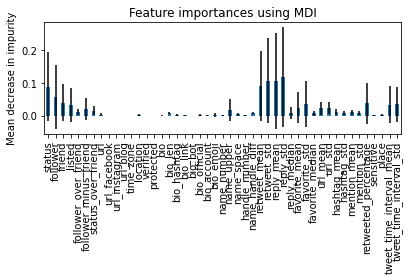

In [38]:
forest_importances = pd.Series(importances, index=realTrain.columns.values.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [34]:
real_versus_inst_veri_RF = trainRF([realTrain], [v2019Train, coaTrain])
print(testRF([realTest], [v2019Test, coaTest], real_versus_inst_veri_RF))

1.0


In [35]:
start_time = time.time()
importances = real_versus_inst_veri_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in real_versus_inst_veri_RF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.011 seconds


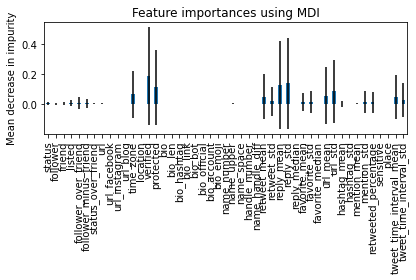

In [36]:
forest_importances = pd.Series(importances, index=realTrain.columns.values.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()